# Rectified Flow

Flow Straight and Fast: Learning to Generate and Transfer Data with Rectified Flow, Liu et al., 2022. [[arXiv:2209.03003](https://arxiv.org/abs/2209.03003)]

## 1. Prepare Dataset

Define the gaussian mixture distribution as the target distribution.

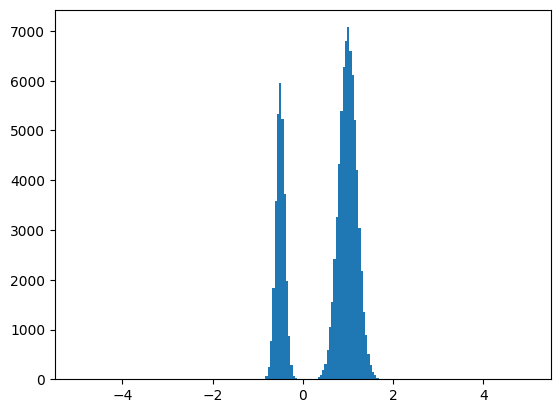

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributions as D

mixture = D.MixtureSameFamily(
    D.Categorical(torch.tensor([0.3, 0.7])),
    D.Normal(torch.tensor([-0.5, 1.0]), torch.tensor([0.1, 0.2])),
)
# target distribution
X = mixture.sample((100000, 1))

_ = plt.hist(X, bins=np.linspace(-5, 5, 200), label="data")

## 2. Define Model

Define MLP backbone and rectified flow framework.

In [2]:
import torch
import torch.nn as nn

from flowmodels import RectifiedFlow


class Backbone(nn.Module):
    def __init__(self, dim: int = 1, layers: int = 3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, 64),
            *[
                submodule
                for _ in range(layers)
                for submodule in (nn.ReLU(), nn.Linear(64, 64))
            ],
            nn.ReLU(),
            nn.Linear(64, dim),
        )

    def forward(self, x_t: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        return self.net.forward(torch.cat([x_t, t[:, None].to(x_t)], dim=-1))


model = RectifiedFlow(Backbone())
model

RectifiedFlow(
  (velocity_estim): Backbone(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): ReLU()
      (8): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

## 3. Train Rectified FLow

Train the ODE model with the prepared dataset.

  0%|          | 0/1000 [00:00<?, ?it/s]

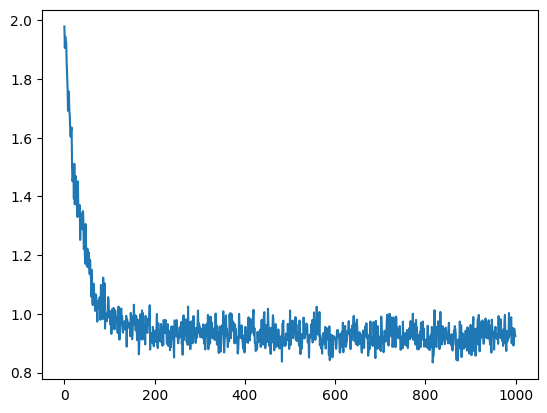

In [3]:
import torch
from tqdm.auto import tqdm

# training configurations
LR = 0.001
TRAIN_STEPS = 1000
BATCH_SIZE = 2048

# train
model.train()
optim = torch.optim.Adam(model.parameters(), LR)

losses = []
with tqdm(range(TRAIN_STEPS)) as pbar:
    for i in pbar:
        loss = model.loss(sample=X[torch.randint(0, len(X), (BATCH_SIZE,))])
        # update
        optim.zero_grad()
        loss.backward()
        optim.step()

        # log
        loss = loss.detach().item()
        losses.append(loss)
        pbar.set_postfix_str(f"loss: {loss:.2f}")

plt.plot(losses)

## 4. Test the model

Sample from the model, inspect the trajectory.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

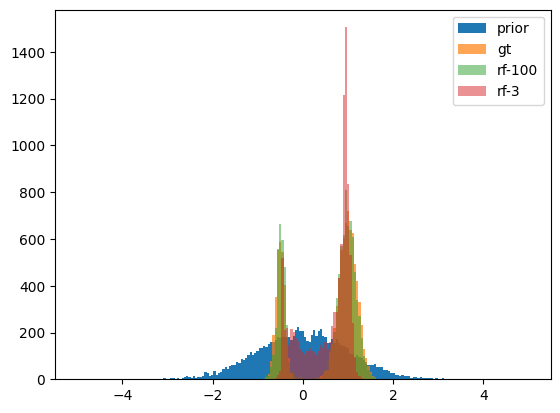

In [4]:
n = 10000
sample = torch.randn(n, X.shape[-1])
x_3, _ = model.sample(sample, verbose=lambda x: tqdm(x, leave=False), steps=3)
x_100, _ = model.sample(sample, verbose=lambda x: tqdm(x, leave=False), steps=100)

plt.hist(sample, bins=np.linspace(-5, 5, 200), label="prior")
plt.hist(X[:n], bins=np.linspace(-5, 5, 200), label="gt", alpha=0.7)
plt.hist(x_100.view(-1), bins=np.linspace(-5, 5, 200), label="rf-100", alpha=0.5)
plt.hist(x_3.view(-1), bins=np.linspace(-5, 5, 200), label="rf-3", alpha=0.5)
plt.legend()
_xticks, _ = plt.xticks()

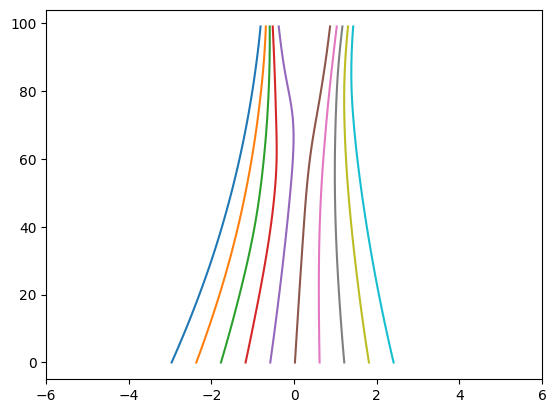

In [5]:
# Sampling trajectory
n = 200
x_t, x_ts = model.sample(torch.linspace(-3, 3, n)[:, None], steps=100)
for i in range(10):
    plt.plot(torch.tensor([_x_t[i * 20].item() for _x_t in x_ts]), range(len(x_ts)))
    plt.xticks(_xticks)

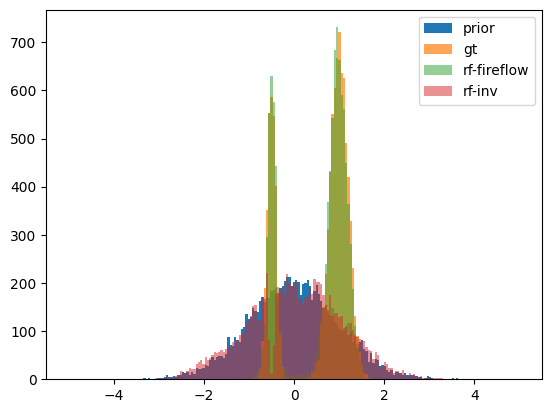

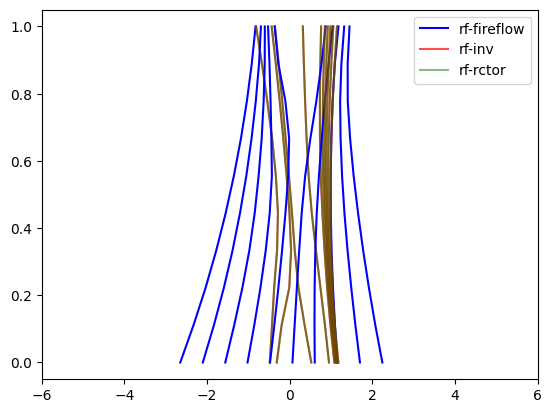

In [6]:
# FireFlow
# , Fast Inversion of Rectified Flow for Image Semantic Editing, Deng et al., 2024.
from flowmodels import FireFlowSolver
from flowmodels.basis import VelocityInverter

fireflow = FireFlowSolver()

n = 10000
sample = torch.randn(n, X.shape[-1])
x_t, _ = fireflow.solve(model, sample)
y_t, _ = fireflow.solve(VelocityInverter(model), X)
plt.hist(sample, bins=np.linspace(-5, 5, 200), label="prior")
plt.hist(X[:n], bins=np.linspace(-5, 5, 200), label="gt", alpha=0.7)
plt.hist(x_t.view(-1), bins=np.linspace(-5, 5, 200), label="rf-fireflow", alpha=0.5)
plt.hist(y_t.view(-1)[:n], bins=np.linspace(-5, 5, 200), label="rf-inv", alpha=0.5)
plt.legend()
_xticks, _ = plt.xticks()

# plot trajectory
n = 200
_, x_ts = fireflow.solve(model, torch.linspace(-3, 3, n)[:, None])
y_t, y_ts = fireflow.solve(model, X.view(-1).sort()[0][:: len(X) // n, None])
_, r_ts = fireflow.solve(model, y_t)

plt.figure()
for i in range(10):
    plt.plot(
        torch.tensor([_x_t[i * 20].item() for _x_t in x_ts]),
        np.linspace(0, 1, len(x_ts)),
        "b",
        **({} if i > 0 else {"label": "rf-fireflow"}),  # labeling on first plot only
    )
    plt.plot(
        torch.tensor([_x_t[i * 20].item() for _x_t in y_ts]),
        np.linspace(0, 1, len(y_ts))[::-1],
        "r",
        alpha=0.7,
        **({} if i > 0 else {"label": "rf-inv"}),  # labeling on first plot only
    )
    plt.plot(
        torch.tensor([_x_t[i * 20].item() for _x_t in y_ts]),
        np.linspace(0, 1, len(y_ts))[::-1],
        "g",
        alpha=0.5,
        **({} if i > 0 else {"label": "rf-rctor"}),  # labeling on first plot only
    )
    plt.xticks(_xticks)
plt.legend()

### Reflow

Reflow the model to straighten the trajectory.

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

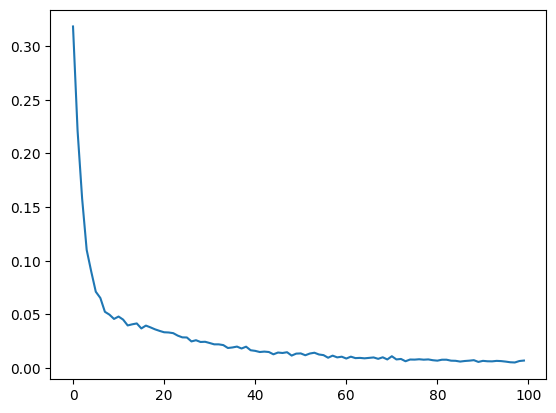

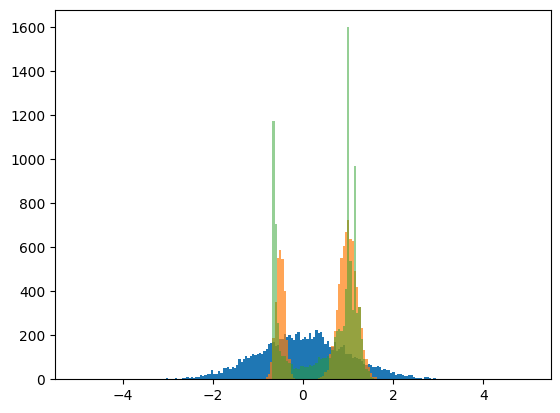

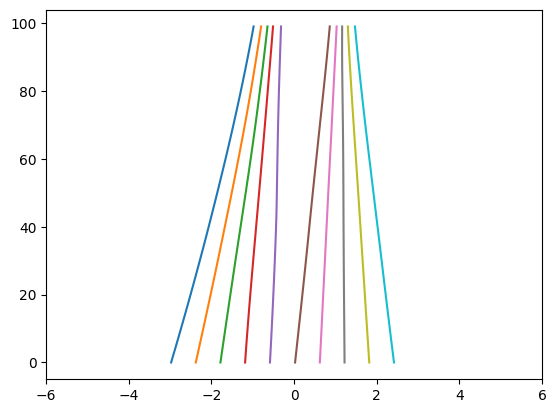

In [7]:
# Reflow
LR = 0.001
SAMPLE_STEPS = 100
TRAIN_STEPS = 100
BATCH_SIZE = 2048

n = 10000
prior = torch.randn(n, X.shape[-1])

optim = torch.optim.Adam(model.parameters(), LR)
losses = model.reflow(
    optim,
    prior,
    training_steps=TRAIN_STEPS,
    batch_size=BATCH_SIZE,
    sample=SAMPLE_STEPS,
    verbose=lambda x: tqdm(x, leave=False),
)

plt.plot(losses)

# plot the trajectory
plt.figure()

n = 10000
sample = torch.randn(n, X.shape[-1])
x_t, _ = model.sample(sample, steps=1)
plt.hist(sample, bins=np.linspace(-5, 5, 200), label="prior")
plt.hist(X[:n], bins=np.linspace(-5, 5, 200), label="gt", alpha=0.7)
plt.hist(x_t.view(-1), bins=np.linspace(-5, 5, 200), label="reflow_1", alpha=0.5)

plt.figure()
n = 200
x_t, x_ts = model.sample(torch.linspace(-3, 3, n)[:, None], steps=100)
for i in range(10):
    plt.plot(torch.tensor([_x_t[i * 20].item() for _x_t in x_ts]), range(len(x_ts)))
    plt.xticks(_xticks)

### Distillation

Distill the model for single-step generation

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

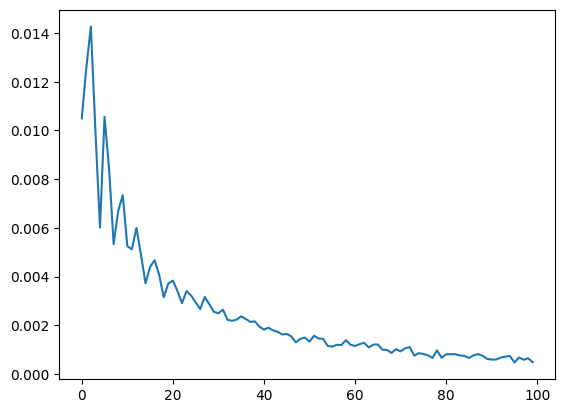

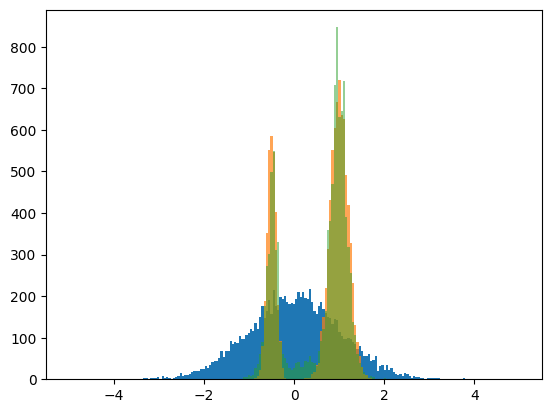

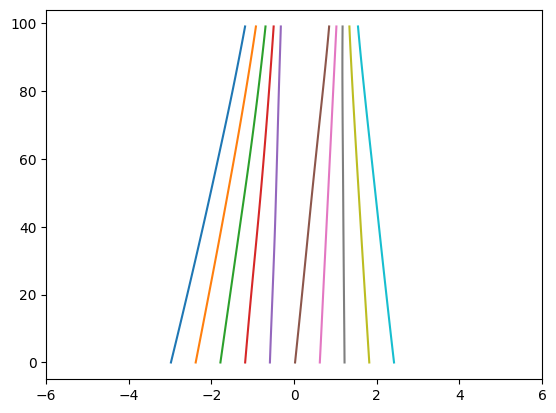

In [8]:
# Distillation
LR = 0.001
SAMPLE_STEPS = 100
TRAIN_STEPS = 100
BATCH_SIZE = 2048

n = 10000
prior = torch.randn(n, X.shape[-1])

optim = torch.optim.Adam(model.parameters(), LR)
losses = model.distillation(
    optim,
    prior,
    training_steps=TRAIN_STEPS,
    batch_size=BATCH_SIZE,
    sample=SAMPLE_STEPS,
    verbose=lambda x: tqdm(x, leave=False),
)

plt.plot(losses)

# plot the trajectory
plt.figure()

n = 10000
sample = torch.randn(n, X.shape[-1])
x_t, _ = model.sample(sample, steps=1)
plt.hist(sample, bins=np.linspace(-5, 5, 200), label="prior")
plt.hist(X[:n], bins=np.linspace(-5, 5, 200), label="gt", alpha=0.7)
plt.hist(x_t.view(-1), bins=np.linspace(-5, 5, 200), label="reflow_1", alpha=0.5)

plt.figure()
n = 200
x_t, x_ts = model.sample(torch.linspace(-3, 3, n)[:, None], steps=100)
for i in range(10):
    plt.plot(torch.tensor([_x_t[i * 20].item() for _x_t in x_ts]), range(len(x_ts)))
    plt.xticks(_xticks)